In [1]:
import numpy as np
from astropy.io import fits
from scipy.stats import gamma
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 25})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
import sys
sys.path.append('../../../2YR-UNI/Blok2/AppStat2019/External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax  
import winsound

In [2]:
def trial(var, mean, trials=10000):
    k = mean**2/var
    t = var/mean
    rand = np.rint(np.random.gamma(k, scale=t, size=trials))
    return rand

In [3]:
# Get COSMOS data
file_name = 'cosmos2015_D17_v2.0_zmin-zmax.fits' #davidzon17 paper

# Data for observed galaxies
hdul = fits.open(file_name)
ra = hdul[1].data["RA_J2000"] # Right ascension
dec = hdul[1].data["DEC_J2000"] # Declination
z = hdul[1].data["ZBEST"] # Redshift
mass = hdul[1].data["logMASS_MED"] # Mass
hdul.close()

In [4]:
# Get CV values from cosmic variance calculator 
# Currently the code is set up to compare to the JADES Deep survey
path = "../CV_Vals/cv_jades_deep.csv"
df = pandas.read_csv(path)
z_vals = df["z"].values
dz_vals = df["dz"].values


In [5]:
# Define a grid of pointings
# Grid of squares with the same size as the JADES Deep survey

##IS JADES Deep a square??????
side1 = 4.8/60 #Is this right?
side2= 9.6/60
ra_min = np.min(ra)
dec_min = np.min(dec)
ra_max = np.max(ra)
dec_max = np.max(dec)

ra_vals = np.arange(ra_min, ra_max, side2)
dec_vals = np.flip(np.arange(dec_max, dec_min, -side1))

In [6]:
dec_min

1.6145321034

[Text(0, 0.5, 'Declination'),
 Text(0.5, 0, 'Right ascencion'),
 Text(0.5, 1.0, 'COSMOS2015 Ultravista Field')]

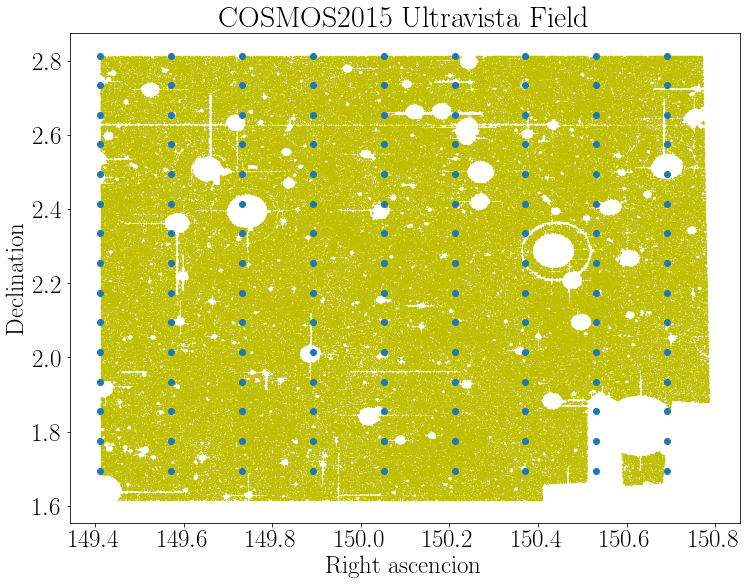

In [7]:
# Plot of grid of pointings
fig, ax=plt.subplots(figsize=(12,9))
ax.scatter(ra,dec,s=0.1,c='y')

x, y = np.meshgrid(ra_vals, dec_vals)
ax.scatter(x,y)
ax.set(xlabel='Right ascencion', ylabel='Declination', title='COSMOS2015 Ultravista Field')

In [10]:
# Find the number of galaxies in each grid cell within a certain z, mass range and compare to gamma distribution
def num_gals(z_val, dz_val, m, plot=False, close=True, save=False):
    sig = df.loc[df['z'] == z_val][[str(m)]].values[0][0]
    # Define z range
    min_z = z_val - dz_val/2
    max_z = z_val + dz_val/2

    num_gal = []
    
    # Find number of galaxies in each cell within z, mass range
    for i in range(len(ra_vals)-1):
        for j in range(len(dec_vals)-1):
            ra_1 = ra_vals[i]
            dec_1 = dec_vals[j]
            ra_2 = ra_1 + side2
            dec_2 = dec_1 + side1

            # Check if there are low z galaxies in the cell before counting high z galaxies
            index_low = np.where((ra > ra_1) & (ra < ra_2) & (dec > dec_1) & (dec < dec_2) & (z < 1))
        
            # Currently checks if there are at least 1500 low redshift galaxies in a pointing before counting
            # the number of high z galaxies. This is designed to throw out pointings with very few galaxies at
            # any redshift so as not to skew the high z results.
# TO DO: Calculate a good value for the number of low z galaxies for this limit
            if len(z[index_low]) > 2000:
                index = np.where((ra > ra_1) & (ra < ra_2) & (dec > dec_1) & (dec < dec_2) & (z < max_z) & (z > min_z)
                                & (mass > m) & (mass < m + 0.5))
                num_gal.append(len(z[index]))
    # Compare distribution of high z galaxies to gamma distribution
    if any(num_gal):
        vals, counts = np.unique(num_gal, return_counts=True)
        
        # TO DO: Fix bug in gamma distribution mean.
        # There is currently an issue where the mean of the true distribution and the gamma distrbution do not match
        # despite being assigned as the same value. This may arise from when the gamma distribution is integrated.
        
        # TO DO: Update this mean to reflect the luminosity function used in the mean-median calculations.
        
        mean = np.mean(num_gal) # Use the mean number of galaxies from the COSMOS data set as the mean of the distribution.
        
        var = sig**2*mean**2 # Calculate variance from the cosmic variance calculator values
        k = mean**2/var
        t = var/mean
        
        # Integrate the gamma function to get a discrete PMF
        rv = gamma(k, scale = t)
        x_int = np.append(0.001,np.arange(0.5, max(num_gal)+1.5))
        pdf = rv.pdf(x_int)
        x = np.arange(max(num_gal)+1)
        
        gamma_int = np.zeros(len(x))
        
        for i in range(len(x_int)-2):
            gamma_int[i] = np.trapz([pdf[i], pdf[i+1]],[x[i], x[i+1]])
        
        # Normalize gamma distribution, COSMOS data
        gamma_int = gamma_int / np.sum(gamma_int)
        err=np.sqrt(counts) / np.sum(counts)
        counts_nn=counts
        counts = counts / np.sum(counts)
#         print('gamma mean/var is {}, {}'.format(gamma.stats(k, scale=t, moments='m'),gamma.stats(k,scale=t, moments='v')))
#         print('True mean/var is {}, {}'.format(mean,var))
#         print('{}'.format(k*t))
        # Plot to compare true and simulated distribution
        
        if(plot):
            fig, ax = plt.subplots(figsize = (12, 9))
            ax.plot(x,rv.pdf(x), 'ro-', label='straight pdf')
            ax.plot(x,gamma_int,'bo-',label="Gamma Distribution",marker = "o", markersize = 5)
            ax.plot(vals,counts, 'ro', label="COSMOS2015")
            ax.errorbar(vals,counts, yerr=err, c = 'k', elinewidth = 1, \
                           capsize = 2, ls = 'none')
            xtick=np.arange(0,max(num_gal)+2,2)
            ax.set(xticks=xtick, xlabel="Number of Galaxies", ylabel="Fraction of Pointings", title="46"r"$arcmin^2$ ""pointing, z = %.3f, Mass %.1f-%.1f "r"$M_{\odot}$" % (z_val, m, m+0.5))
            plt.legend()

            if save==True:
                plt.savefig("figs/CV_z%.3f_m%.1f.pdf" % (z_val, m))
            if close==True:
                plt.close()
        g=trial(var,mean,trials=int(1e6))
    return x, rv.pdf(x), gamma_int, vals, counts, err, g, counts_nn

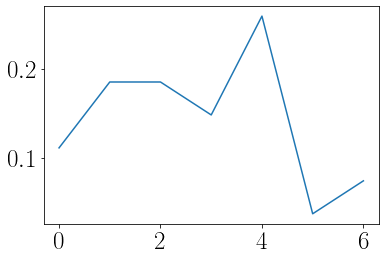

In [11]:
masses = [8.5, 9.0, 9.5, 10.0, 10.5, 11.0]
k=50
x, pdf, gamma_int, vals, counts, err, g, counts_nn = num_gals(z_vals[k], dz_vals[k], masses[0], close=True)
plt.plot(vals,counts)

6 panels. Expected time is 96 s


<IPython.core.display.Javascript object>


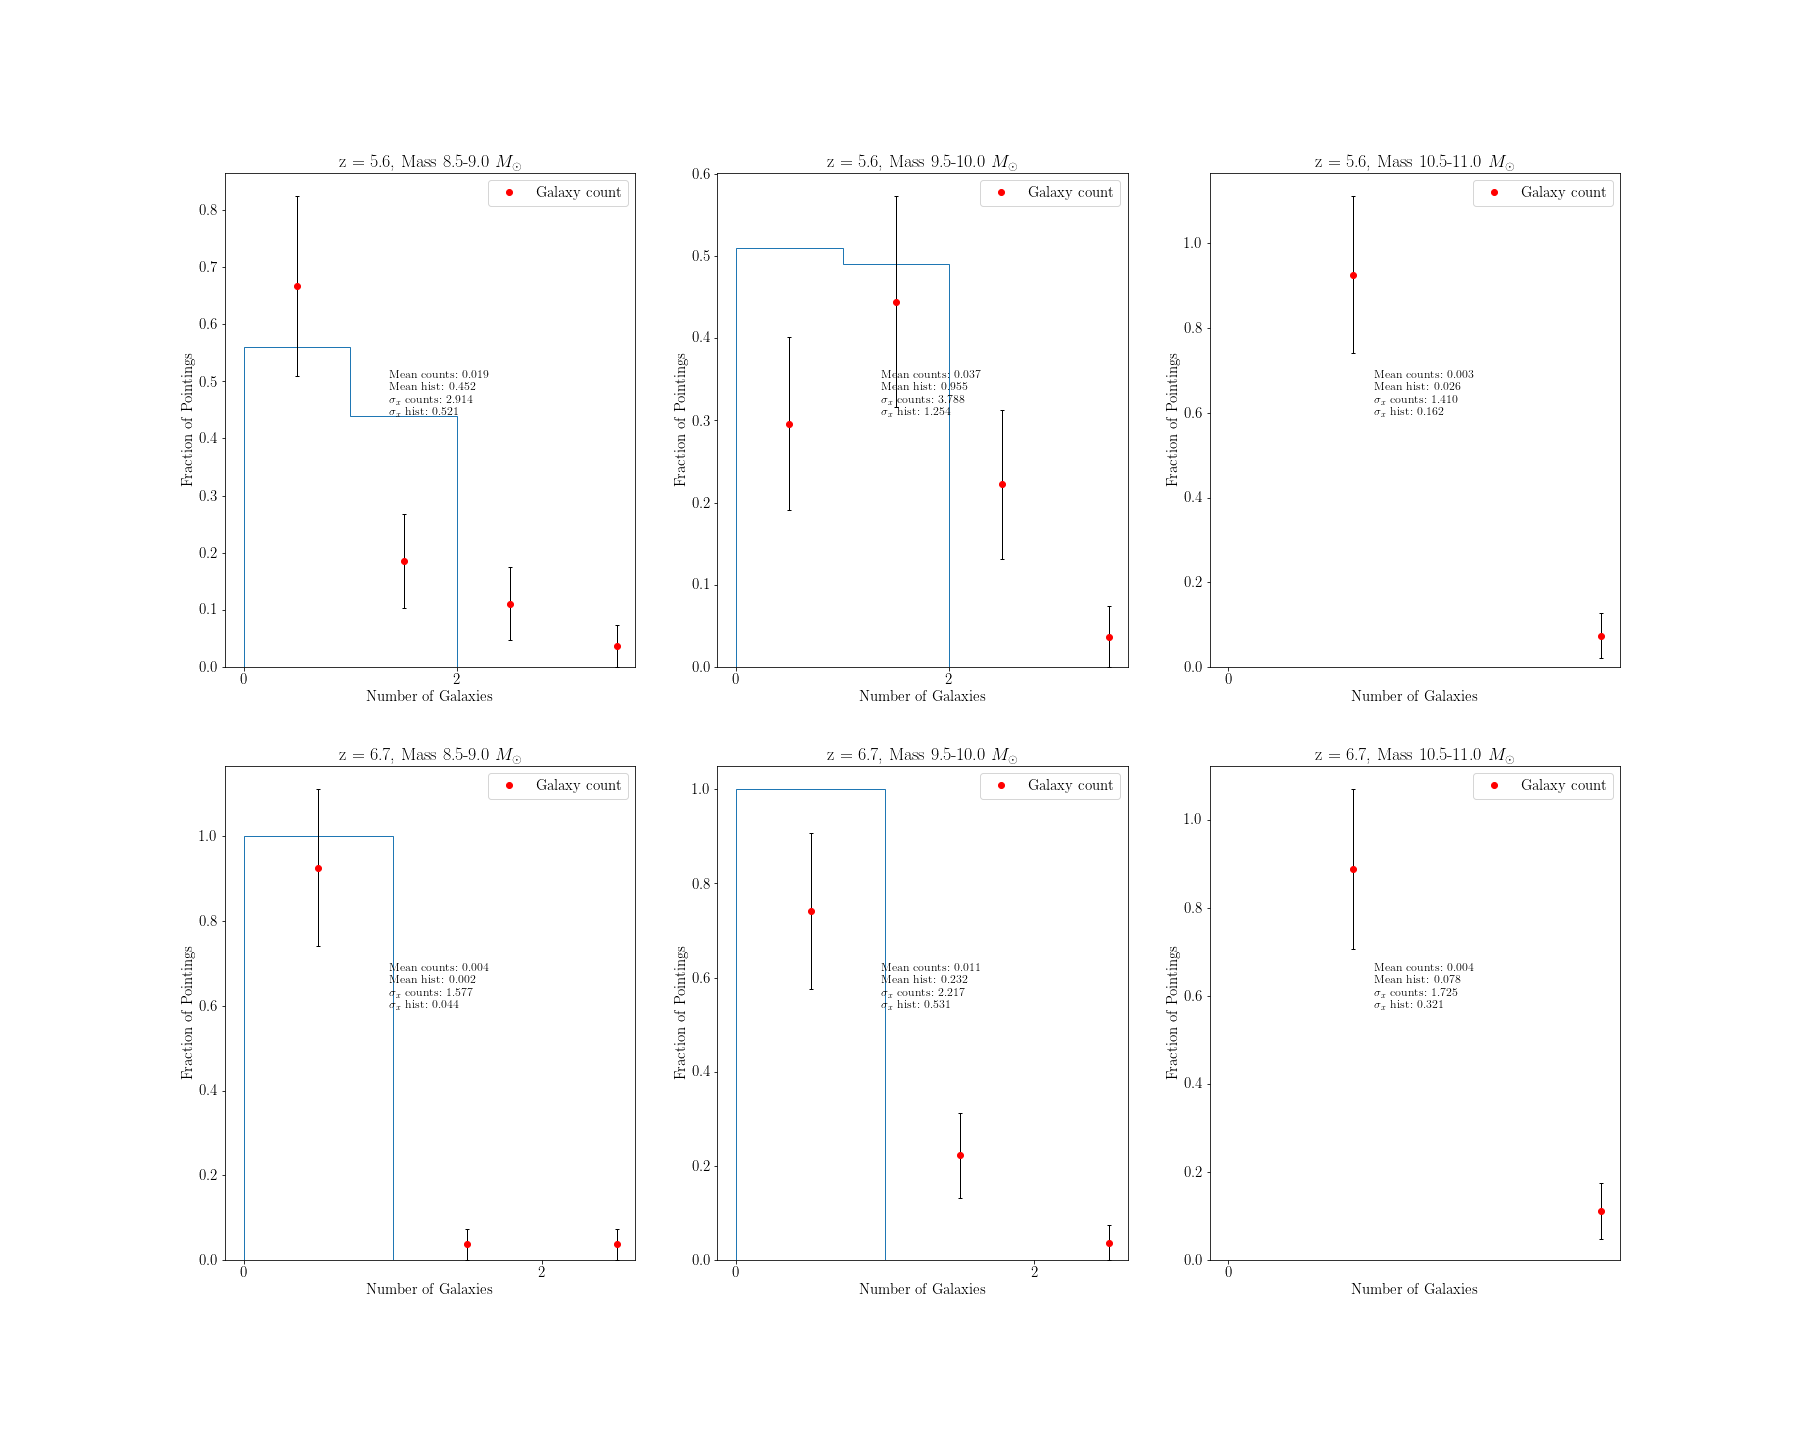

In [14]:
%matplotlib notebook
# Generate all plots
plt.rcParams.update({'font.size': 15})
# %time
indices = range(51,60,3)
masses = [8.5, 9.0, 9.5, 10.0, 10.5, 11.0]
indices=indices[1:]
masses=masses[::2]
print(len(indices)*len(masses),'panels. Expected time is {} s'.format(len(indices)*len(masses)*16))
fig, ax = plt.subplots(nrows=len(indices),ncols=len(masses), figsize = (25, 20))
k=0
# fig
for i in indices:
    j=0
    for m in masses:
        z_val = z_vals[i]
        dz_val = dz_vals[i]
        x, pdf, gamma_int, vals, counts, err, g, counts_nn = num_gals(z_val, dz_val, m, plot=False, close=False)
        pdf[0]=1-np.sum(pdf[1:])
#         ax[k][j].plot(x+0.5,pdf, 'bo-', label='straight pdf')
#         ax[k][j].plot(x,gamma_int,'bo-',label="Gamma Distribution",marker = "o", markersize = 5)
        ax[k][j].hist(g,bins=np.arange(max(vals)),density=1,histtype='step')
        me=np.sum(vals*counts_nn)/sum(counts_nn)**2
        v=np.sqrt(1/((len(vals))-1)*np.sum(counts_nn*(vals-me)**2))
        d = {'Mean counts:': me,
             'Mean hist:': np.mean(g),
             r'$\sigma_x$ counts:': v,
            r'$\sigma_x$ hist:': np.std(g),
            }        
        text = nice_string_output(d, extra_spacing=2, decimals=3)
        add_text_to_ax(0.4, 0.6, text, ax[k][j], fontsize=12)
        ax[k][j].plot(vals+0.5,counts, 'ro', label='Galaxy count') 
        ax[k][j].errorbar(vals+0.5,counts, yerr=err, c = 'k', elinewidth = 1, \
                       capsize = 2, ls = 'none')
        xtick=np.arange(0,max(x)+1,2)
        ax[k][j].set(xticks=xtick, xlabel="Number of Galaxies", ylabel="Fraction of Pointings", title="z = %.1f, Mass %.1f-%.1f "r"$M_{\odot}$" % (np.round(z_val,2), m, m+0.5))
        ax[k][j].legend()
        j+=1
    k+=1
fig.tight_layout
duration = 250  # milliseconds
freq = 500  # Hz
winsound.Beep(freq, duration)